# 다양한 OCR 모델 비교하기
1. 서비스 기획
- 서비스명 : MENU 판 OCR
- 서비스 개요

메뉴판에 있는 사진과 글씨를 통해서 잘 모르는 언어라도 어떤 음식인 지 잘 인식할 수 있는 서비스이다. 
## 1. 검증용 데이터셋 준비
텍스트의 모양과 크기, 배치, 노이즈 등 OCR API의 성능에 영향을 미치는 요인들이 있다.위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 한다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요하다.

- Google OCR
- Keras-OCR
- Tesseract

## 2. OCR 테스트
### 2-1 Google OCR

In [20]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_18/ocr_python/menu'
file_list = os.listdir(img_dir)
file_list

['image6.PNG',
 'image9.PNG',
 'image4.PNG',
 'image10.PNG',
 'image3.PNG',
 'image2.PNG',
 'image7.PNG',
 'image5.PNG']

In [21]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [22]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_18/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[image6.PNG]
Texts:

"@123RF
PELICION
DELICIOUS
MENU
ALWAYS FRESH
O12BRF
23RF®
"

"@123RF"

"PELICION"

"DELICIOUS"

"MENU"

"ALWAYS"

"FRESH"

"O12BRF"

"23RF®"
bounds: (197,215),(235,176),(252,192),(213,231)

[image9.PNG]
Texts:

"Coffee
WS
"

"Coffee"

"WS"
bounds: (3,356),(45,356),(45,375),(3,375)

[image4.PNG]
Texts:

"COCKTAIL
MENU
iStock
Margarita
In veniam esse in aute ad elusmod et
Labore et pariatur ee ipsum. Corsectetur et
ullamco ut minim..0.00s
Pina Colada O
In veniam esse in aute ad elusmod et
Sto.
Ey Bloody MaryD
Labore et pariatur ea ipsum. Consectetur et
ulamco ut minim...0.00s
In veniam esse in aute ad elusmod et
Labore et pariatur eo ipsum. Consectetur et
ullamco ut minim..0.ces
Blue Volcano D
In veniam esse in aute ad elusmod et.
Labore et pariatur ea ipsum, Consectetur et
ullamco ut minim.0.00s
Tequila Sunrise
In veniam esse in aute ad eiusatod et
Labore et pariatur ea ipum. Consectetur et
ulamco ut minim.0.00s
"

"COCKTAIL"

"MENU"

"iStock"

"Margarita"

"In"

"v

### 2-2 Keras-ocr

In [23]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [24]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

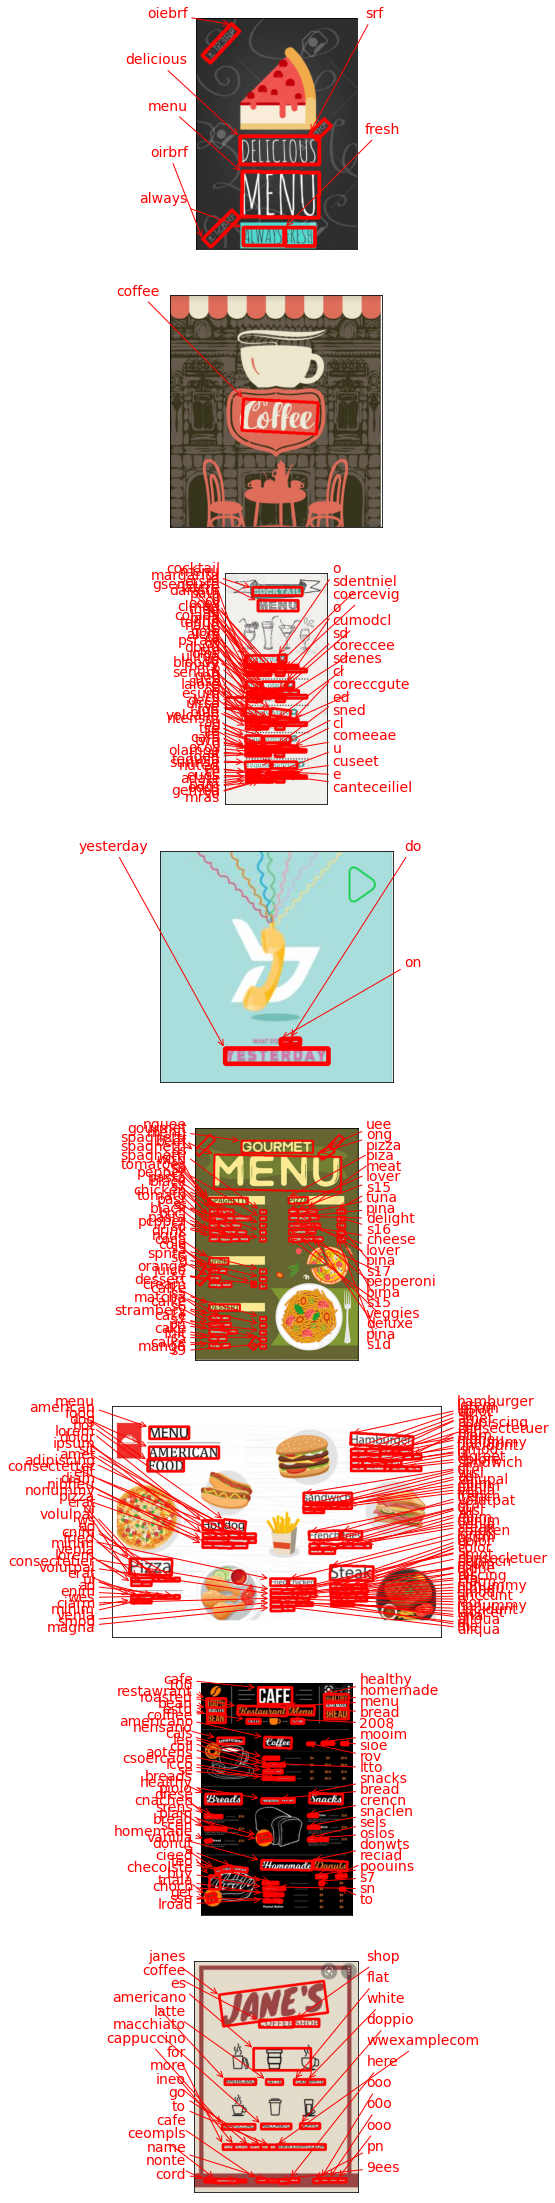

In [25]:
#시각화
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2-3 Tesseract

In [41]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [42]:
save_dir = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_18/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[image6.PNG]
Cannot recognize characters from image6.PNG
[image9.PNG]
Cannot recognize characters from image9.PNG
[image4.PNG]
Cannot recognize characters from image4.PNG
[image10.PNG]
Cannot recognize characters from image10.PNG
[image3.PNG]
Cannot recognize characters from image3.PNG
[image2.PNG]
Cannot recognize characters from image2.PNG
[image7.PNG]
Cannot recognize characters from image7.PNG
[image5.PNG]
Cannot recognize characters from image5.PNG


## 3. 테스트 결과 정리

In [28]:
def compare_ocr(file):
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))

[keras-ocr]


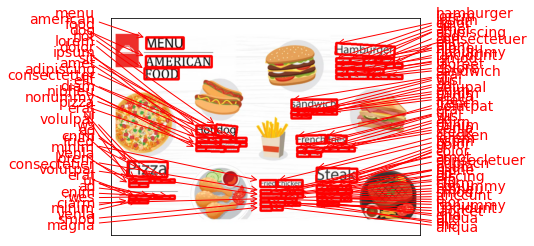


[Google OCR]
Texts:

"MENU
Hamburger
AMERICAN
FOOD
Lorem ipsum dolor sit amet,
consectetuer adipiscing elit, sed
diam nonummy nibheu
ismod tincidunt ut laoreet dolore
sandwich
Erat volutpat. Ut wisi enim ad
minim venia
Hot dog
French fries
Lorem ipsum dolor sit amet
consectetuer adipiscing elit
diam nonummy nibheu
Erat volutpat. Ut wisi enim ad
minim venia
Pizza
Steak
Erat volutpat. Ut wisi enim ad
minim venia
Fried chicken
Lorem ipsum dolor sit amet
consectetuer adipiscing elit
diam nonummy nibheu
ismod tincidunt ut laoreet
Lorem ipsum dolor sit
consectetuer adipiscin
diam nonummy nibhe
ismod tincidunt ut laor
Erat volutpat. Ut wisi onim ad
minim venia
magna aliqua.
magna aliqua.
"

"MENU"

"Hamburger"

"AMERICAN"

"FOOD"

"Lorem"

"ipsum"

"dolor"

"sit"

"amet,"

"consectetuer"

"adipiscing"

"elit,"

"sed"

"diam"

"nonummy"

"nibheu"

"ismod"

"tincidunt"

"ut"

"laoreet"

"dolore"

"sandwich"

"Erat"

"volutpat."

"Ut"

"wisi"

"enim"

"ad"

"minim"

"venia"

"Hot"

"dog"

"Fren

In [29]:
compare_ocr('image2.PNG')

[keras-ocr]


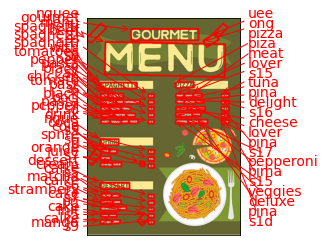


[Google OCR]
Texts:

"GOURMET
MENU
SPAGHETTI
PIZZA
Beef spaghetti
$5
Meat Lover Pizza
Spaghetti with Tomatoes
$6
$15
ongree
Tuna Delight Pizza
Black Pepper Pasta
$16
$7
Cheese Lover Pizza
Tomato Chicken Pasta
$17
$8
Pepperoni Pizza
Black Pepper Beef Pasta
$18
$9
Veggies Deluxe Pizza
$19
Drink
$5
gtrea
Sprite
$6
on
$7
Orange Juice
DESSERT
Cream cake
$5
Matcha cake
$6
Strawberry cake
gtre
$7
Fruit cake
$8
Mango cake
$9
gtree
2pngtree
"

"GOURMET"

"MENU"

"SPAGHETTI"

"PIZZA"

"Beef"

"spaghetti"

"$5"

"Meat"

"Lover"

"Pizza"

"Spaghetti"

"with"

"Tomatoes"

"$6"

"$15"

"ongree"

"Tuna"

"Delight"

"Pizza"

"Black"

"Pepper"

"Pasta"

"$16"

"$7"

"Cheese"

"Lover"

"Pizza"

"Tomato"

"Chicken"

"Pasta"

"$17"

"$8"

"Pepperoni"

"Pizza"

"Black"

"Pepper"

"Beef"

"Pasta"

"$18"

"$9"

"Veggies"

"Deluxe"

"Pizza"

"$19"

"Drink"

"$5"

"gtrea"

"Sprite"

"$6"

"on"

"$7"

"Orange"

"Juice"

"DESSERT"

"Cream"

"cake"

"$5"

"Matcha"

"cake"

"$6"

"Strawberry"

"cake"

"gtre"

"$7

In [30]:
compare_ocr('image3.PNG')

[keras-ocr]


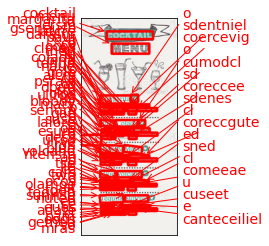


[Google OCR]
Texts:

"COCKTAIL
MENU
iStock
Margarita
In veniam esse in aute ad elusmod et
Labore et pariatur ee ipsum. Corsectetur et
ullamco ut minim..0.00s
Pina Colada O
In veniam esse in aute ad elusmod et
Sto.
Ey Bloody MaryD
Labore et pariatur ea ipsum. Consectetur et
ulamco ut minim...0.00s
In veniam esse in aute ad elusmod et
Labore et pariatur eo ipsum. Consectetur et
ullamco ut minim..0.ces
Blue Volcano D
In veniam esse in aute ad elusmod et.
Labore et pariatur ea ipsum, Consectetur et
ullamco ut minim.0.00s
Tequila Sunrise
In veniam esse in aute ad eiusatod et
Labore et pariatur ea ipum. Consectetur et
ulamco ut minim.0.00s
"

"COCKTAIL"

"MENU"

"iStock"

"Margarita"

"In"

"veniam"

"esse"

"in"

"aute"

"ad"

"elusmod"

"et"

"Labore"

"et"

"pariatur"

"ee"

"ipsum."

"Corsectetur"

"et"

"ullamco"

"ut"

"minim..0.00s"

"Pina"

"Colada"

"O"

"In"

"veniam"

"esse"

"in"

"aute"

"ad"

"elusmod"

"et"

"Sto."

"Ey"

"Bloody"

"MaryD"

"Labore"

"et"

"pariatur"

"ea"

"

In [31]:
compare_ocr('image4.PNG')

[keras-ocr]


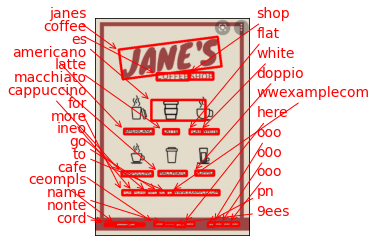


[Google OCR]
Texts:

"JANE'S
COFFEE SHOP
AMERICANO LATTE
FLAT WHITE
CAPPUCCINO MACCHIATO DOPPIO
FOR MORE INFO GO TO WwW.EXAMPLE.COM
namegexomple.com
Cafe name goes here
ph: 000 000 0o0
"

"JANE'S"

"COFFEE"

"SHOP"

"AMERICANO"

"LATTE"

"FLAT"

"WHITE"

"CAPPUCCINO"

"MACCHIATO"

"DOPPIO"

"FOR"

"MORE"

"INFO"

"GO"

"TO"

"WwW.EXAMPLE.COM"

"namegexomple.com"

"Cafe"

"name"

"goes"

"here"

"ph:"

"000"

"000"

"0o0"
bounds: (380,575),(399,575),(399,583),(380,583)


In [32]:
compare_ocr('image5.PNG')

[keras-ocr]


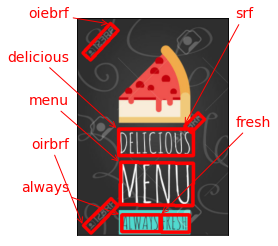


[Google OCR]
Texts:

"@123RF
PELICION
DELICIOUS
MENU
ALWAYS FRESH
O12BRF
23RF®
"

"@123RF"

"PELICION"

"DELICIOUS"

"MENU"

"ALWAYS"

"FRESH"

"O12BRF"

"23RF®"
bounds: (197,215),(235,176),(252,192),(213,231)


In [17]:
compare_ocr('image6.PNG')

[keras-ocr]


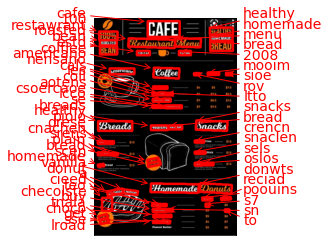


[Google OCR]
Texts:

"= CAFE =
100%
HEALTHY
HOMEMADE
ROASTED
Restaurant Menu
BEAN
BREAD
ESTD
2008
Americano
Coffee
regular
medium
large
BEST
Americane
$4
$5
$7.5
Iked Cafe Latte
$5
$7.5
$8.5
Matcha Coffe
$7
$8.5
$12
Iced Mik Cappuccino
$7
$7.5
$9
Breads
Snacks
Healthy Bread
Plain Bread
$15
French Fries
Lam
Chicken Bread
$15
Chicken Stick
$15
PLAIN
BREAD
Beef Bread
$15
Spicy Nachos
$15
Homemade Donuts
Vanilla Donut
Regular
Special
Green Tea
$7
$9
Chocolate Milk
$8
$10
BUY 1
GET 1
Vanilla Choco
$5
$8
Brown Sugar
$4
$7
Peanut Butter
$5
$8
"

"="

"CAFE"

"="

"100%"

"HEALTHY"

"HOMEMADE"

"ROASTED"

"Restaurant"

"Menu"

"BEAN"

"BREAD"

"ESTD"

"2008"

"Americano"

"Coffee"

"regular"

"medium"

"large"

"BEST"

"Americane"

"$4"

"$5"

"$7.5"

"Iked"

"Cafe"

"Latte"

"$5"

"$7.5"

"$8.5"

"Matcha"

"Coffe"

"$7"

"$8.5"

"$12"

"Iced"

"Mik"

"Cappuccino"

"$7"

"$7.5"

"$9"

"Breads"

"Snacks"

"Healthy"

"Bread"

"Plain"

"Bread"

"$15"

"French"

"Fries"

"Lam"

"Chicken"

"Bread"

In [18]:
compare_ocr('image7.PNG')

[keras-ocr]


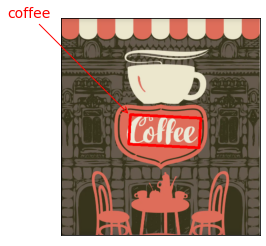


[Google OCR]
Texts:

"Coffee
WS
"

"Coffee"

"WS"
bounds: (3,356),(45,356),(45,375),(3,375)


In [19]:
compare_ocr('image9.PNG')

## 결과
| OCR 모델 평가 기준|Google OCR|keras-OCR|Tesseract|
|------------|:--------:|:-------:|---------------:|
|다른 텍스트에 가려질 때 인식|    x     |    x      |  x   |
|어퍼스트로피 인식| o  |  x  |  x  |  x  | 
|텍스트 크기가 작을 때 인식|o|x|x|
|이미지와 겹쳐진 텍스트 인식|o|x|x|

- Tesseract는 모든 경우에 대해서 인식이 안됐다.
- Google OCR이 가장 훌륭한 모델임을 알 수 있다.
- 메뉴판의 음식과 텍스트들을 인식하기에 가장 좋은 모델은 Google OCR이다.